# OMSCS 7280: Network Science Assignment-5

sshepherd35@gatech.edu

In [1]:
import random
import itertools

import networkx as nx
import numpy as np
import community

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
import seaborn as sns
from scipy import stats
import scipy
from sklearn.metrics import r2_score
from random import sample
%matplotlib inline
import community as community_louvain
import itertools

In [2]:
def summarize_graph(G):
    print('nodes','edges','directed',sep='\t')
    print(G.number_of_nodes(), G.number_of_edges(), G.is_directed(), sep='\t')
    print('density   :', np.round(nx.density(G), 4))
    print('clustering:', np.round(np.mean([e[1] for e in nx.clustering(G).items()]), 4))
    print('3 edges:')
    print(list(G.edges(data=True))[0:3])

---
## Part 1 - Modeling the NCAA College Football 2000 Network ##

In [3]:
G = nx.read_gml("football.gml")

# Print the number of nodes and edges
summarize_graph(G)

nodes	edges	directed
115	613	False
density   : 0.0935
clustering: 0.4032
3 edges:
[('BrighamYoung', 'FloridaState', {}), ('BrighamYoung', 'NewMexico', {}), ('BrighamYoung', 'SanDiegoState', {})]


### 1.1 Structural Properties of the Graph


#### Plot the degree distribution using histogram.

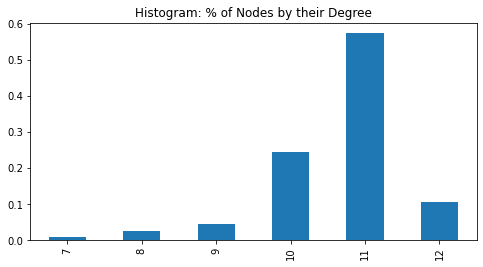

In [4]:
dgrs = [i[1] for i in list(G.degree())]

#print(min(dgrs), max(dgrs))

ax = (
    (pd.Series(dgrs)
    .value_counts()
    .sort_index() / len(dgrs))
    .plot(kind='bar', title='Histogram: % of Nodes by their Degree', figsize=[8,4])
)

#### Louvain community detection

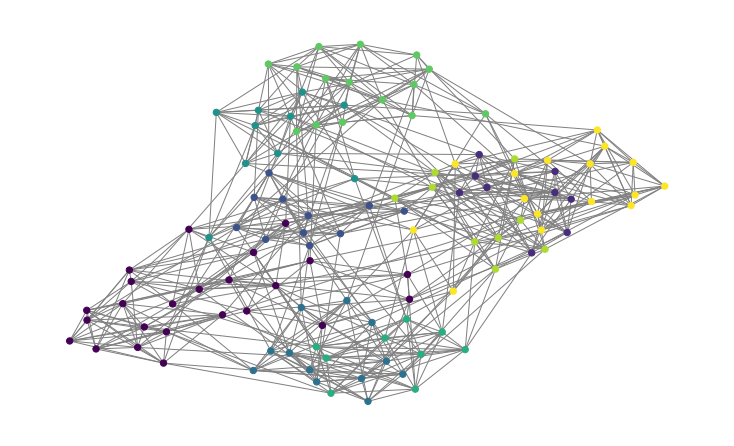

In [5]:
partition = community_louvain.best_partition(
    G,
    random_state=1
)

#comm_labels = [partition[k] for k in list(G.nodes())]
comm_labels = {k: partition[k] for k in list(G.nodes())}
comm_labels = [comm_labels[k] for k in list(G.nodes())]

plt.figure(figsize=(10,6))
nx.draw_spring(G, node_size=40, node_color=comm_labels, edge_color='gray')
plt.show()

#### Plot the inter-community connection density as heatmap.

community_b,0,1,2,3,4,5,6,7,8
community_a,,,,,,,,,
0,0.365942,0.013889,0.022727,0.041667,0.029167,0.055556,0.005556,0.013889,0.023438
1,0.013889,1.000000,0.020202,0.009259,0.077778,0.024691,0.014815,0.024691,0.041667
2,0.022727,0.020202,0.800000,0.037879,0.027273,0.040404,0.060606,0.020202,0.022727
3,0.041667,0.009259,0.037879,0.727273,0.016667,0.055556,0.011111,0.027778,0.015625
4,0.029167,0.077778,0.027273,0.016667,0.777778,0.011111,0.066667,0.077778,0.006250
5,0.055556,0.024691,0.040404,0.055556,0.011111,1.000000,0.000000,0.037037,0.013889
6,0.005556,0.014815,0.060606,0.011111,0.066667,0.000000,0.542857,0.014815,0.033333
7,0.013889,0.024691,0.020202,0.027778,0.077778,0.037037,0.014815,0.861111,0.083333
8,0.023438,0.041667,0.022727,0.015625,0.006250,0.013889,0.033333,0.083333,0.491667


Heatmap: Inter and Intra Community Density


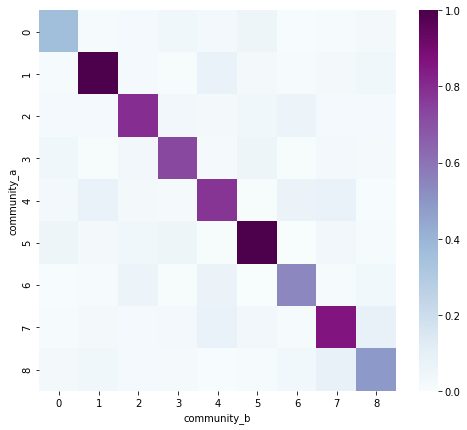

In [6]:
cls = sorted(list(set(comm_labels)))

results = []

for c in cls:
    for cc in cls:
        if c == cc:
            c_nodes = [n[0] for n in partition.items() if n[1] == c]
            sg = nx.subgraph(G, c_nodes)
            #print(c, cc, sg.number_of_nodes(), nx.density(sg))
            val = nx.density(sg)
        else:
            c_nodes  = [n[0] for n in partition.items() if n[1] == c]
            cc_nodes = [n[0] for n in partition.items() if n[1] == cc]
            sgc  = nx.subgraph(G, c_nodes)
            sgcc = nx.subgraph(G, cc_nodes)
            shared_edges = list(nx.edge_boundary(G, sgc, sgcc))
            val = len(shared_edges) / (len(c_nodes) * len(cc_nodes))
        
        results.append( (c,cc,val) )
        
pvt = (
    pd.DataFrame.from_records(results, columns=['community_a','community_b','value'])
    .pivot(index='community_a', columns='community_b', values='value')
)

display(pvt)

print('Heatmap: Inter and Intra Community Density')
plt.figure(figsize=(8,7))
fig = sns.heatmap(pvt, cmap="BuPu")
plt.show()

#### Print the:
- network diameter,
- characteristic path length (CPL),
- average clustering coefficient,
- transitivity, and assortativity. 

In [7]:
def describe_graph(G):
    desc = {
        'diameter': nx.diameter(G),
        'cpl': nx.average_shortest_path_length(G),
        'clustering': np.mean([e[1] for e in nx.clustering(G).items()]),
        'transitivity': nx.transitivity(G),
        'assortativity': nx.degree_assortativity_coefficient(G)
    }
    return desc

g_desc = describe_graph(G)

for k in g_desc.keys():
    print(k.ljust(20), g_desc[k])

diameter             4
cpl                  2.5081617086193746
clustering           0.40321601104209803
transitivity         0.4072398190045249
assortativity        0.16244224957444287


### 1.2 Configuration Model

#### Generate Graphs

In [8]:
dgrs = [i[1] for i in G.degree()]

cmg_results = []
for i in range(100):
    cmg = nx.configuration_model(dgrs, create_using=nx.Graph())
    cmg_desc = describe_graph(cmg)
    cmg_results.append( (
        cmg_desc['diameter'],
        cmg_desc['cpl'],
        cmg_desc['clustering'],
        cmg_desc['transitivity'],
        cmg_desc['assortativity']
    ) )
    
cmg_results_df = pd.DataFrame.from_records(cmg_results, columns=['diameter','cpl','clustering','transitivity','assortativity'])

#### Plot (Histogram /Boxplot):
 - network diameter,
 - CPL,
 - average clustering coefficient,
 - transitivity,
 - assortativity. 

diameter


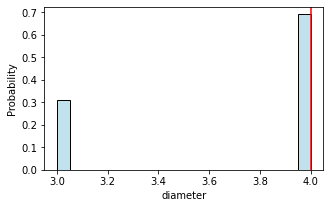

cpl


<Figure size 432x288 with 0 Axes>

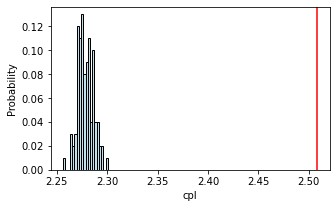

clustering


<Figure size 432x288 with 0 Axes>

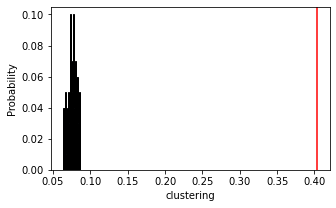

transitivity


<Figure size 432x288 with 0 Axes>

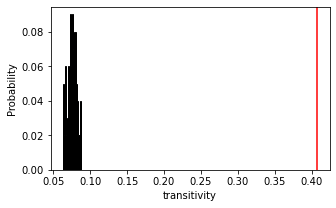

assortativity


<Figure size 432x288 with 0 Axes>

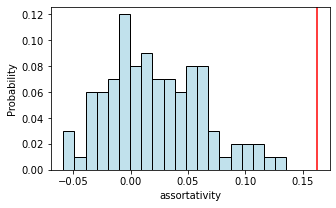

<Figure size 432x288 with 0 Axes>

In [9]:
def get_histograms(results_df, true_graph_metrics):
    for c in results_df.columns.tolist():
        print(c)
        true_value = true_graph_metrics[c]
        plt.figure(figsize=(5,3))
        fig = sns.histplot(results_df[c], stat='probability', color='lightblue', bins=20)
        fig.axvline(true_value, color='red')
        plt.show()
        plt.clf()
        
get_histograms(cmg_results_df, g_desc)

### 1.3 Stochastic Block Model Graphs

#### Generate Graphs    

In [10]:
sbmg_results = []
for i in range(100):
    sbmg = nx.stochastic_block_model(
        sizes=pd.value_counts(comm_labels).sort_index().tolist(),
        p=np.array(pvt)
    )
    sbmg_desc = describe_graph(sbmg)
    sbmg_results.append( (
        sbmg_desc['diameter'],
        sbmg_desc['cpl'],
        sbmg_desc['clustering'],
        sbmg_desc['transitivity'],
        sbmg_desc['assortativity']
    ) )
    
sbmg_results_df = pd.DataFrame.from_records(sbmg_results, columns=['diameter','cpl','clustering','transitivity','assortativity'])

#### Plot (Histogram /Boxplot):
 - network diameter,
 - CPL,
 - average clustering coefficient,
 - transitivity,
 - assortativity. 

diameter


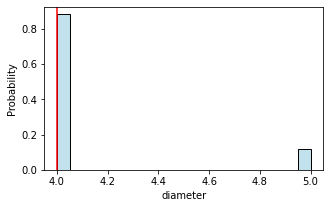

cpl


<Figure size 432x288 with 0 Axes>

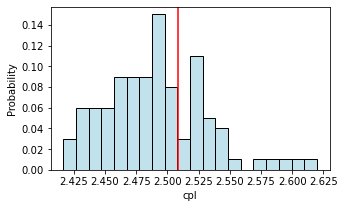

clustering


<Figure size 432x288 with 0 Axes>

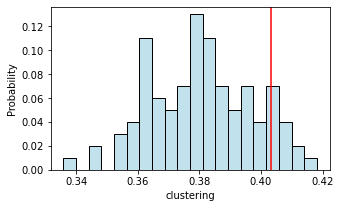

transitivity


<Figure size 432x288 with 0 Axes>

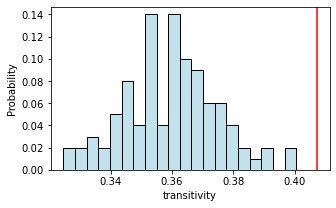

assortativity


<Figure size 432x288 with 0 Axes>

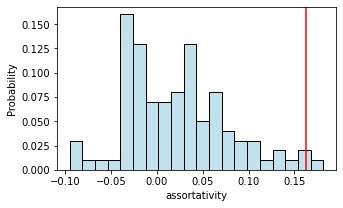

<Figure size 432x288 with 0 Axes>

In [11]:
get_histograms(sbmg_results_df, g_desc)

### 1.4 Hierarchical Random Graphs

#### Read dendrogram for node connection probabilities via lowest common ancestor

In [12]:
dendrogram = nx.read_gml("football-hrg.gml")

print(dendrogram.number_of_nodes(), dendrogram.number_of_edges())

#plt.figure(figsize=(8,6))
#nx.draw_kamada_kawai(dendrogram, node_size=20)

229 228


#### Generate Graphs

In [13]:
dnds = list(dendrogram.nodes)
dlvs = sorted([i for i in dnds if i[0] != '_'])
dend_data = dict(dendrogram.nodes(data=True))
pairs = list(itertools.combinations(dlvs, 2))

hrg_results = []
for i in range(100):
    lcas = nx.lowest_common_ancestors.all_pairs_lowest_common_ancestor(dendrogram, pairs=pairs)
    edges = []
    for pair_info in lcas:
        prob = dend_data[pair_info[1]]['p']
        if np.random.uniform(0,1) < prob:
            edges.append(pair_info[0])

    hrg = nx.Graph()
    hrg.add_edges_from(edges)
    if len( list(nx.selfloop_edges(hrg)) ):
        print("warning: self loop detected on iteration", i)
    hrg_desc = describe_graph(hrg)
    hrg_results.append( (
        hrg_desc['diameter'],
        hrg_desc['cpl'],
        hrg_desc['clustering'],
        hrg_desc['transitivity'],
        hrg_desc['assortativity']
    ) )
        
hrg_results_df = pd.DataFrame.from_records(hrg_results, columns=['diameter','cpl','clustering','transitivity','assortativity'])

#### Plot (Histogram /Boxplot):
 - network diameter,
 - CPL,
 - average clustering coefficient,
 - transitivity,
 - assortativity. 

diameter


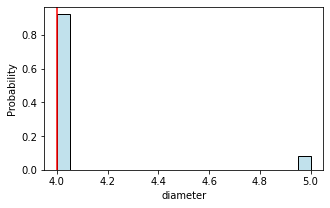

cpl


<Figure size 432x288 with 0 Axes>

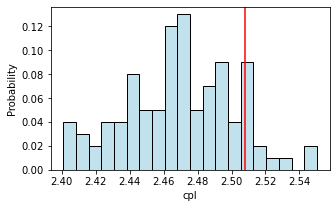

clustering


<Figure size 432x288 with 0 Axes>

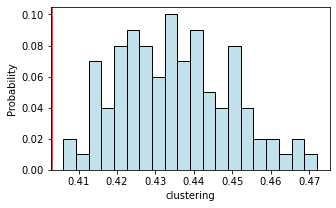

transitivity


<Figure size 432x288 with 0 Axes>

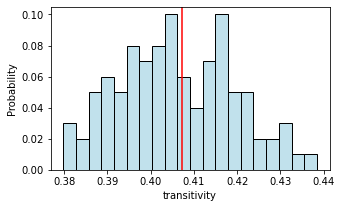

assortativity


<Figure size 432x288 with 0 Axes>

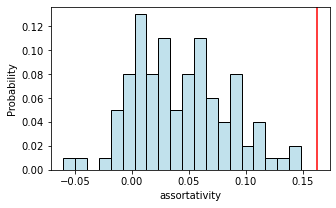

<Figure size 432x288 with 0 Axes>

In [14]:
get_histograms(hrg_results_df, g_desc)

### 1.5 Best Fit

#### Print the average value and standard deviation for:
- the diameter
- CPL
- average clustering coefficient
- transitivity
- assortativity 

In [15]:
cmg_results_df['model']  = 'configuration_model'
sbmg_results_df['model'] = 'stochastic_block_model'
hrg_results_df['model']  = 'hierarchical_random_graphs'

(
    pd.concat([cmg_results_df,sbmg_results_df,hrg_results_df])
    .groupby('model')
    .agg(['mean','std'])
    .loc[['configuration_model','stochastic_block_model','hierarchical_random_graphs']]
    #.transpose()
    #.plot(kind='bar')
)

diameter                 cpl           clustering  \
                               mean       std      mean       std       mean   
model                                                                          
configuration_model            3.69  0.464823  2.278391  0.007922   0.075438   
stochastic_block_model         4.12  0.326599  2.490342  0.040492   0.380756   
hierarchical_random_graphs     4.08  0.272660  2.469466  0.032385   0.434660   

                                     transitivity           assortativity  \
                                 std         mean       std          mean   
model                                                                       
configuration_model         0.005934     0.075345  0.005945      0.021596   
stochastic_block_model      0.016818     0.359763  0.015323      0.021629   
hierarchical_random_graphs  0.014610     0.406043  0.013302      0.042707   

                                      
                                 std  
model                                 
configuration_model         0.041828  
stochastic_block_model      0.056231  
hierarchical_random_graphs  0.042269

#### Hypothesis Tests
- Print the following
- gP-Values for diameter,
- CPL,
- average clustering coefficient,
- transitivity,
- assortativity 

In [16]:
cnt = 0
for df in [cmg_results_df,sbmg_results_df,hrg_results_df]:
    cnt += 1
    if cnt == 1:
        print("* Configuration Model *")
    if cnt == 2:
        print("\n* Stochastic Block Graph Model *")
    if cnt == 3:
        print("\n* Hierarchical Random Graph Model *")
    
    print(''.ljust(15), 'sample', 'emprcl', 'diff', 'pval', sep='\t\t')
    for m in g_desc.keys():
        #print(m)
        samp_vals = df[m].tolist()
        emp_val   = g_desc[m]
        pval = stats.ttest_1samp(samp_vals, emp_val).pvalue
        
        print(m.ljust(15), np.round(np.mean(samp_vals), 4), 
              np.round(emp_val, 4), np.round(np.mean(samp_vals) - emp_val, 4), np.round(pval, 4), sep='\t\t')

* Configuration Model *
               		sample		emprcl		diff		pval
diameter       		3.69		4		-0.31		0.0
cpl            		2.2784		2.5082		-0.2298		0.0
clustering     		0.0754		0.4032		-0.3278		0.0
transitivity   		0.0753		0.4072		-0.3319		0.0
assortativity  		0.0216		0.1624		-0.1408		0.0

* Stochastic Block Graph Model *
               		sample		emprcl		diff		pval
diameter       		4.12		4		0.12		0.0004
cpl            		2.4903		2.5082		-0.0178		0.0
clustering     		0.3808		0.4032		-0.0225		0.0
transitivity   		0.3598		0.4072		-0.0475		0.0
assortativity  		0.0216		0.1624		-0.1408		0.0

* Hierarchical Random Graph Model *
               		sample		emprcl		diff		pval
diameter       		4.08		4		0.08		0.0042
cpl            		2.4695		2.5082		-0.0387		0.0
clustering     		0.4347		0.4032		0.0314		0.0
transitivity   		0.406		0.4072		-0.0012		0.3706
assortativity  		0.0427		0.1624		-0.1197		0.0


#### Which model do you think best approximates the empirical network? Explain your answer. 

Of the 3 options, I think the Hierarchical Random Graph model best approximates the empirical network because:
- 2 / 5 of the metrics have p-values > .0001 in my runs, vs. 0 / 5 for the other two models
- It produces the closest diameter and transitivity values (compared to the other 2)
- It has the closest assortativity of the 3 models, even though the difference is still large

---
## Part 2 - Estimate the number of nodes and edges in Slashdot dataset

#### Load the slashdot graph

In [17]:
## Part 2 - Estimate the number of nodes and edges in Slashdot dataset ##
G = nx.read_edgelist("soc-Slashdot0902.txt", delimiter="\t", create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))

summarize_graph(G)

nodes	edges	directed
82168	870161	True
density   : 0.0001
clustering: 0.0572
3 edges:
[('0', '1', {}), ('0', '2', {}), ('0', '3', {})]


#### Part 2.1 - capture-recapture estimation of node quantity using a sample size of 2,000

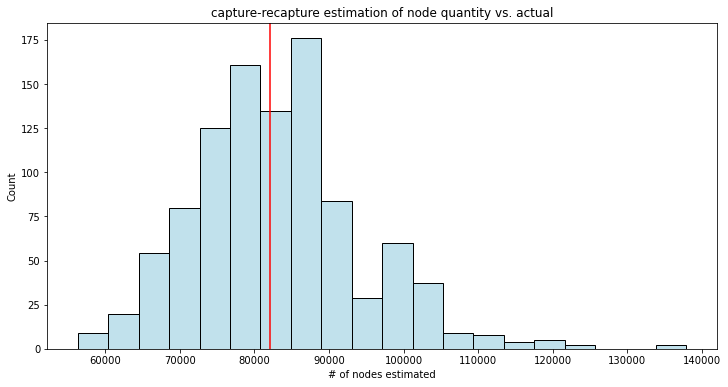

<Figure size 432x288 with 0 Axes>

In [19]:
nds = list(G.nodes)

cc_ests = []
for i in range(1000):
#     if i % 100 == 0:
#         print('on:', i)
    n1 = random.sample( nds, k = 2000 )
    n2 = random.sample( nds, k = 2000 )
    n3 = set(n1).intersection(n2)
    est = len(n1) * len(n2) / len(n3)
    cc_ests.append(est)
    
plt.figure(figsize=(12,6))
fig = sns.histplot(cc_ests, color='lightblue', bins=20)
fig.axvline(G.number_of_nodes(), color='red')
fig.set_title('capture-recapture estimation of node quantity vs. actual')
fig.set_xlabel('# of nodes estimated')
plt.show()
plt.clf()

#### Part 2.1 - capture-recapture estimation of node quantity using various sample sizes

on sample size: 500
on sample size: 1000
on sample size: 2000
on sample size: 5000
on sample size: 10000


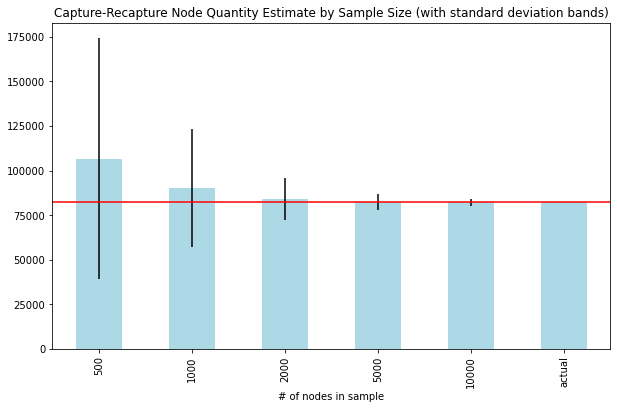

In [20]:
nds = list(G.nodes)

sample_sizes = [500, 1000, 2000, 5000, 10000]

cc_ests_ss = {}
for ss in sample_sizes:
    print('on sample size:', ss)
    cc_ests_ss[ss] = []
    for i in range(1000):
    #     if i % 100 == 0:
    #         print('on:', i)
        n1 = random.sample( nds, k = ss )
        n2 = random.sample( nds, k = ss )
        n3 = set(n1).intersection(n2)
        if len(n3) > 0:
            est = len(n1) * len(n2) / len(n3)
        else:
            est = None
        cc_ests_ss[ss].append(est)
        
cc_ests_ss['actual'] = [len(nds) for r in range(len(cc_ests_ss[10000]))]
        
means = pd.DataFrame(data=cc_ests_ss).mean()
stds  = pd.DataFrame(data=cc_ests_ss).std()

fig = (
    means
    .plot(kind='bar', yerr=stds, figsize=[10,6], color='lightblue', xlabel='# of nodes in sample',
          title='Capture-Recapture Node Quantity Estimate by Sample Size (with standard deviation bands)')
)
fig.axhline(G.number_of_nodes(), color='red')

The estimations get closer to the actual value and have decreased variance as the sample size increases.  At lower sample sizes, the approach seems to over-estimate.

#### Part 2.3 - Edge quantity estimate via induced subgraph sampling and Horvitz-Thompson estimation

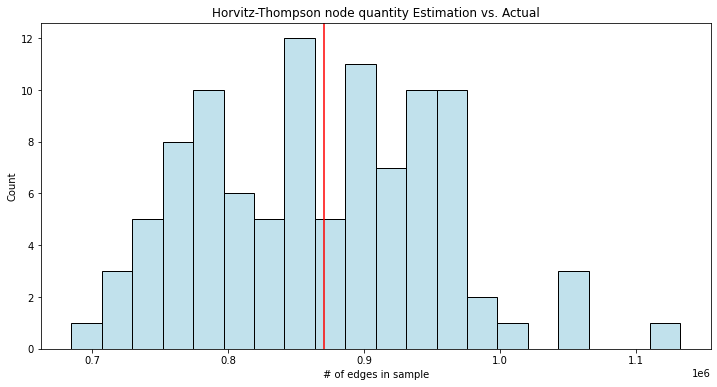

<Figure size 432x288 with 0 Axes>

In [21]:
nds = list(G.nodes)

ht_ests = []
for i in range(100):
    nd_samp = random.sample(nds, k=5000)
    sg = G.subgraph(nd_samp)
    scale_factor = ( len(nds) * ( len(nds) - 1 ) ) / ( 5000 * (5000 - 1) )
    est = int(np.round( sg.number_of_edges() * scale_factor ))
    ht_ests.append(est)
    
plt.figure(figsize=(12,6))
fig = sns.histplot(ht_ests, color='lightblue', bins=20)
fig.axvline(G.number_of_edges(), color='red')
fig.set_title('Horvitz-Thompson node quantity Estimation vs. Actual')
fig.set_xlabel('# of edges in sample')
plt.show()
plt.clf()

---
# END

#### Requirements output

In [22]:
! conda list -e > requirements.txt